In [1]:
# Import qiskit

import qiskit

In [2]:
# Import all the necessary libraries (not all are necessary but this is what Mohammed had)

from qiskit.aqua.algorithms import VQE, NumPyEigensolver,NumPyMinimumEigensolver
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, L_BFGS_B, NELDER_MEAD
from qiskit.aqua.operators import Z2Symmetries, MatrixOp
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.aqua.operators import (TPBGroupedWeightedPauliOperator,
                                   WeightedPauliOperator,
                                   MatrixOperator)
import warnings
import time

In [4]:
# Import the Hamiltonian from my Mathematica .txt file (which I uploaded to my Jupyter files)

start_time = time.time()
warnings.filterwarnings("ignore")
file_path = fr'./Hbhinterior16x16.txt'
H_file = np.loadtxt(file_path)

HH = MatrixOp(primitive=H_file)
HHH = HH.to_pauli_op()
qubitOp = HHH.to_legacy_op()

# Print some items that gives us info on the Hamiltonian so that we know we did the above step correctly
# Info such as size of Hamiltonian (16x16), number of qubits (4), and how the Hamiltonian is mapped onto the qubits
# It includes the identity matrix, I (beginning of each thing), X gates, Y gates, Z gates (createsd in strings in
# order to represent Hamiltonian)

print("Size of Hamiltonian:", np.shape(H_file))
print(qubitOp)
print(qubitOp.print_details())
type(qubitOp)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (256, 256)
Representation: paulis, qubits: 8, size: 29
IIIIIIII	(42.5+0j)
IIIIIIZZ	(1+0j)
IIIIIZIZ	(2+0j)
IIIIIZZI	(4+0j)
IIIIZIIZ	(4+0j)
IIIIZIZI	(8+0j)
IIIIZZII	(16+0j)
IIIZIIIZ	(-0.5+0j)
IIIZIIZI	(-1+0j)
IIIZIZII	(-2+0j)
IIIZZIII	(-4+0j)
IIZIIIIZ	(-1+0j)
IIZIIIZI	(-2+0j)
IIZIIZII	(-4+0j)
IIZIZIII	(-8+0j)
IIZZIIII	(1+0j)
IZIIIIIZ	(-2+0j)
IZIIIIZI	(-4+0j)
IZIIIZII	(-8+0j)
IZIIZIII	(-16+0j)
IZIZIIII	(2+0j)
IZZIIIII	(4+0j)
ZIIIIIIZ	(-4+0j)
ZIIIIIZI	(-8+0j)
ZIIIIZII	(-16+0j)
ZIIIZIII	(-32+0j)
ZIIZIIII	(4+0j)
ZIZIIIII	(8+0j)
ZZIIIIII	(16+0j)

Program runtime:  233.71216678619385


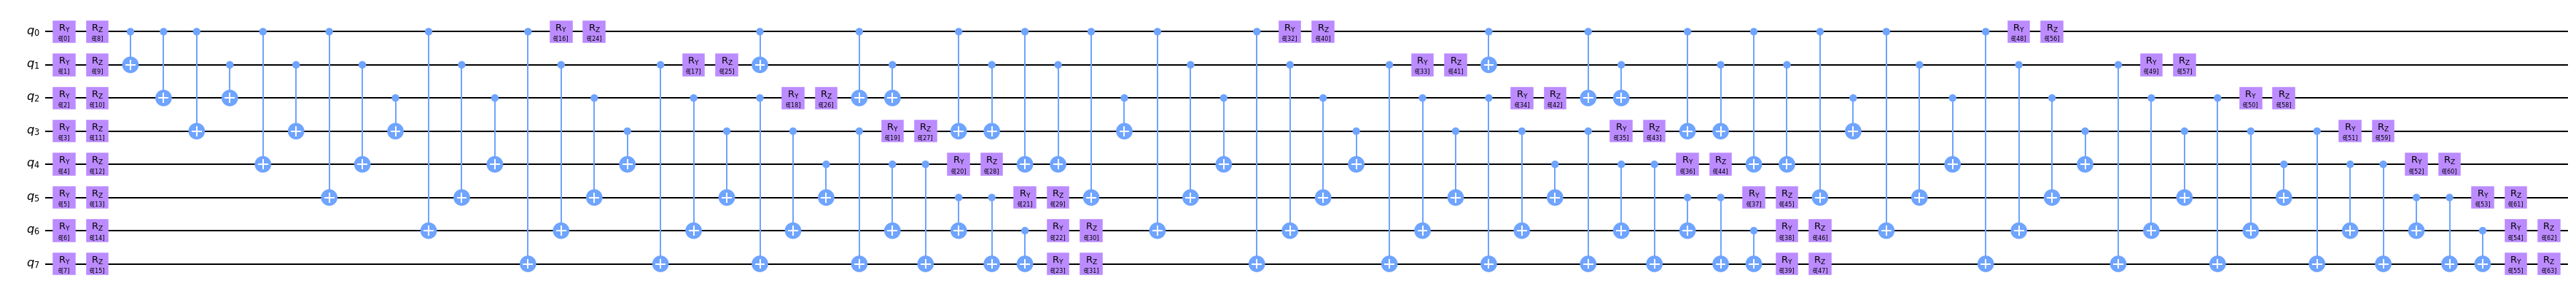

In [5]:
# Next, create the variational form using the function EfficientSU2 (ry variational form)
# Full entanglement measn each qubit is entangled with all the other qubits with a c-not gate
# Reps is the depth of the circuit so each variational form is repeated 3 times (see below 3 sections of blue)

var_form = EfficientSU2(qubitOp.num_qubits,su2_gates=['ry','rz'],entanglement='full',reps=3)

# Display the variational form so that we can see the effect
display(var_form.draw(output='mpl',fold=100))

In [6]:
# Check the exact result that we're getting is correct (i.e. the minimum eigenvalue we'd expect)
# Example: for the SHO we'd expect to get 0.5

exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

Exact Result: [0.]


In [7]:
# This is a callback function that will allow us to store information about the optimizer while the VQE is running.
# This is called when instantiating an object of the VQE class.

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [8]:
start_time = time.time()
warnings.filterwarnings("ignore")
backend = BasicAer.get_backend("statevector_simulator")

# Lists that hold the number of optimizer evalutions and the value at each evaluation
countArr = []
valArr = []

# List that holds the VQE result for each optimizer
vqe_result = []

# List that holds the optimally parametrized variational form (see next section on plotting the wave function)
qc = []

optimizerList = [SLSQP(maxiter=3000), COBYLA(maxiter=4000), L_BFGS_B(maxfun=5000, maxiter=20000), NELDER_MEAD(maxfev=4000)]

for optimizer in optimizerList:

    counts = []
    values = []

    countArr.append(counts)
    valArr.append(values)

    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    ret = vqe.run(backend)
    vqe_result.append(np.real(ret['eigenvalue']))
    qc.append(vqe.get_optimal_circuit())

print("VQE Result:", vqe_result)

end_time = time.time()
runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: [3.374819530351e-06, 0.5002634140618072, 5.4094672612868e-05, 3.3222040121732017]
Program runtime: 1278.574069261551 s


[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.
   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.
   4.   4.   4.   4.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.
   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.
   9.   9.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.
  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  25.  25.
  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.
  25.  25.  25.  25.  25.  25.  36.  36.  36.  36.  36.  36.  36.  36.
  36.  36.  36.  36.  36.  36.  36.  36.  36.  36.  36.  36.  49.  49.
  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.
  49.  49.  64.  64.  64.  64.  64.  64.  64.  64.  64.  64.  64.  64.
  64. 

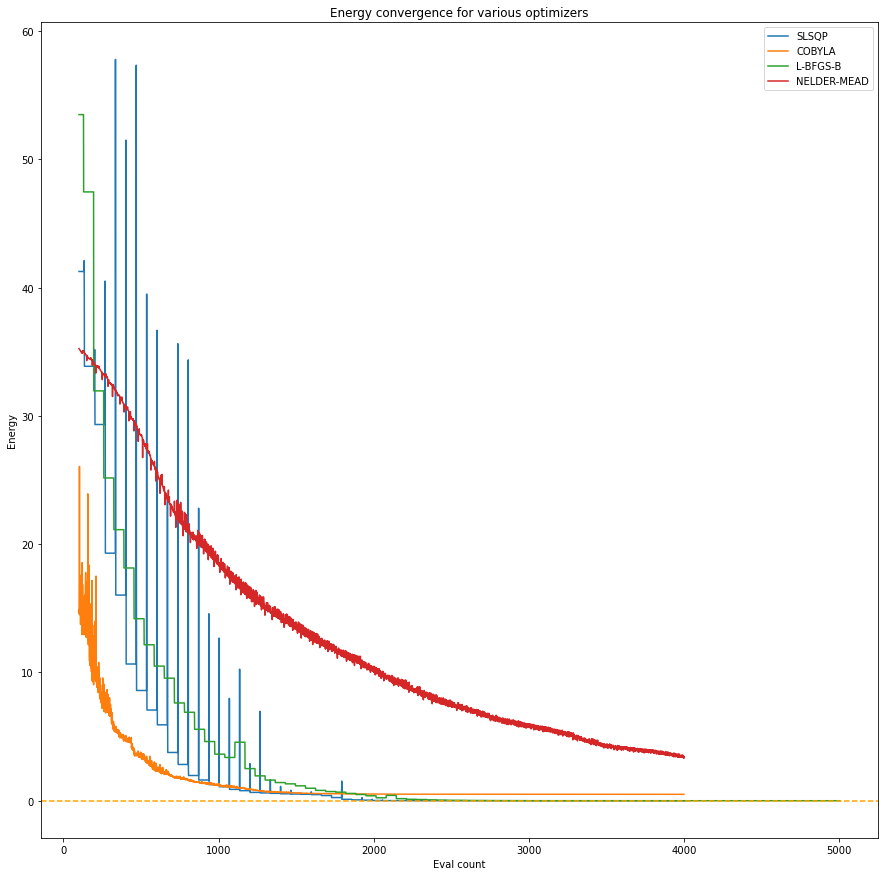

In [9]:
import matplotlib.pyplot as plt

val,vec=np.linalg.eig(H_file)
z = np.argsort(val)
z = z[0:len(H_file)]
energies=(val[z])

print(np.real(energies))

# Plot all of the optimizers in a single convergence plot. If you see that the optimizer isn't converging,
# increase the maximum iterations or maximum function evaluations in the optimizer list above.

labelList = ["SLSQP", "COBYLA", "L-BFGS-B", "NELDER-MEAD", "Exact Energy"]

plt.figure(figsize=(15,15))

for i in range(0,len(optimizerList)):
    # Limit the range of the plot in order to make the convergence of each optimizer more visible.
    plt.plot(countArr[i][100:len(countArr[i])-1], valArr[i][100:len(valArr[i])-1], label=labelList[i])


plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')
plt.axhline(np.real(exact_solution.eigenvalues), color='orange', linestyle='--', label="Exact Energy")

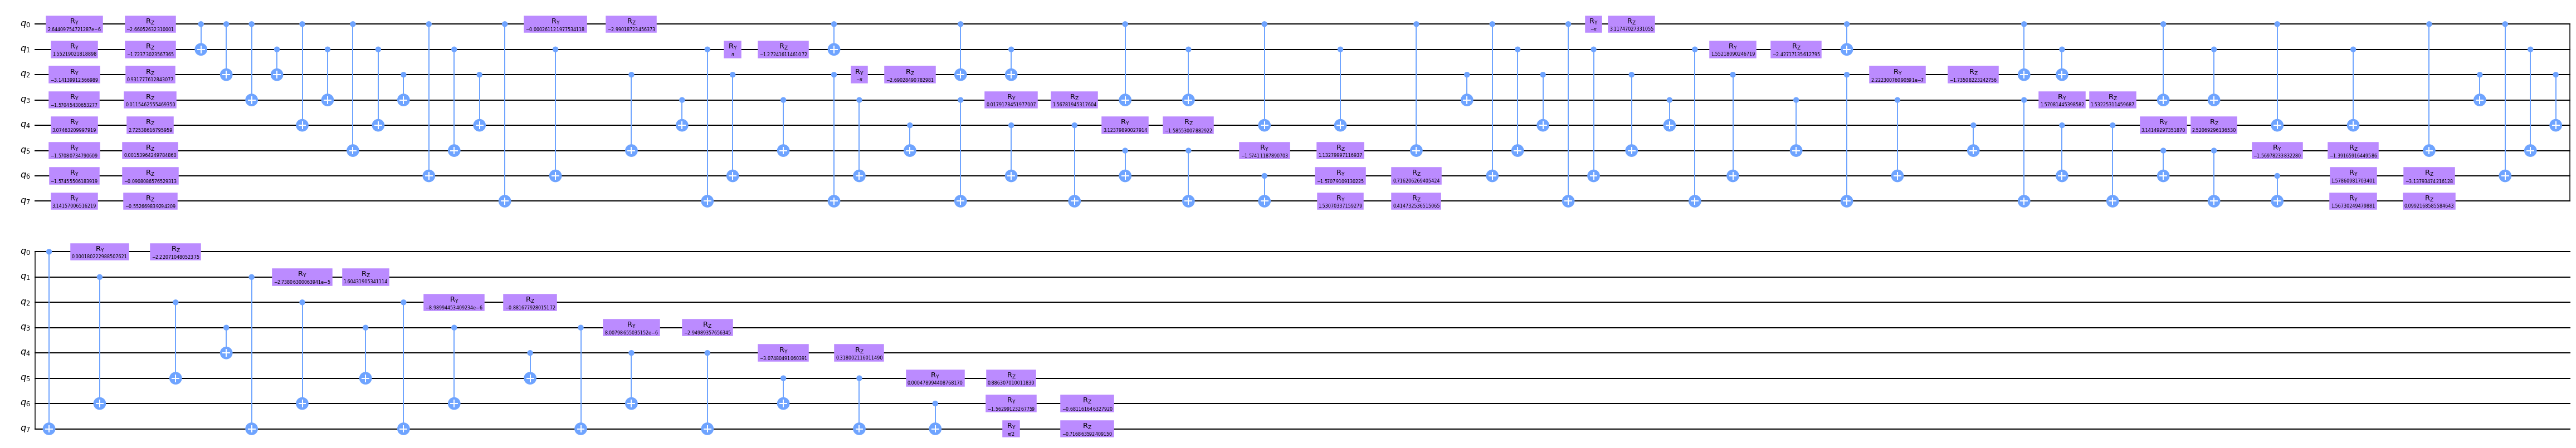

<function matplotlib.pyplot.show(*args, **kw)>

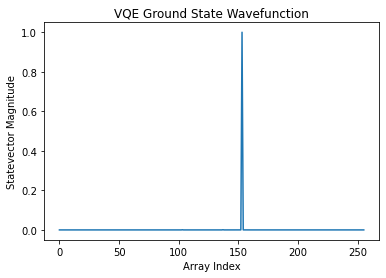

In [10]:
from qiskit import QuantumCircuit, execute

# Find the index of the minimum VQE result from the list of VQE results
best_vqeResult = vqe_result.index(min(vqe_result))

# We will plot the wave function of the best VQE result. To do this, obtain the optimal circuit.
qc_optimal = qc[best_vqeResult]

# Display the optimal circuit. Notice that this is the variational form, but this time,
# the thetas are filled out with numbers.
display(qc_optimal.draw(output='mpl',fold=100))

# Run the statevector simulation on the circuit
qcBackend = BasicAer.get_backend('statevector_simulator')
result = execute(qc_optimal,qcBackend,shots = 1024).result() 
outPut_state = result.get_statevector()

# Display the statevector
plt.plot(abs(outPut_state))
plt.xlabel('Array Index')
plt.ylabel('Statevector Magnitude')
plt.title("VQE Ground State Wavefunction")
plt.show